# Diffusion Curvature for Fast, Point-wise, Noise-Resistant Geometric

Featurization of Graphs and Pointclouds

Kincaid MacDonald [](https://orcid.org/0009-0006-4686-7488) (Yale)  
Dhananjay Bhaskar [](https://orcid.org/0000-0002-7859-8394) (MILA)  
Yanlei Zhang [](https://orcid.org/0000-0002-7859-8394) (MILA)  
Ian Adelstein [](https://orcid.org/0000-0002-7859-8394) (Yale Department of Math)  
Smita Krishnaswamy [](https://orcid.org/0000-0002-7859-8394) (Yale Department of Applied Math, Yale School of Medicine)  
May 24, 2024

For a number of years now work has been proceeding in order to bring to perfection the crudely conceived idea of a machine that would not only supply inverse reactive current for use in unilateral phase detractors, but would also be capable of automatically synchronizing cardinal grammeters. Such a machine is the “Turbo-Encabulator.”

# 1. Introduction

One of the most ubiquitous subjects of analysis in data science is the humble point cloud. The points, by themselves, are high dimensional and noisy; it is up to the data scientist to wring sense out of them. Per the Manifold Hypothesis, we assume the points were sampled on or near the surface of a low-dimensional manifold embedded in high-dimensional Euclidean space. Manifold learning methods, like t-SNE, PHATE, and Diffusion Maps, endeavor to recover salient features of the underlying manifold, like geodesic distances, population clusterings, and dimension, from its high-dimensional noisy sampling ([Maaten and Hinton 2008](#ref-maaten2008VisualizingDataUsing); [Moon et al. 2019](#ref-moon2019VisualizingStructureTransitions); [Coifman and Lafon 2006](#ref-coifman2006DiffusionMaps)).

Curvature is a particularly troublesome geometric property to translate into the discrete, sampled realm. In smooth Riemannian manifolds, curvature is a *local* phenomenon. It can be obtained by fitting osculating circles of radius limiting to zero, or computed from the manifold’s Hessian, using the Second Fundamental Form. None of these translate into the discrete realm. In a sampled manifold, taking a local limit is impossible – one can’t “zoom in” past the sampling of points – and we don’t have access to the parametrization of the manifold or its tangent bundle, without computationally costly and potentially error-prone estimation. Moreover, as our sampling is likely noisy, the curvature can only be recovered over a sufficiently large neighborhood of points to counter the spurious geometric artifacts created noisy sampling. Thus, in the discrete realm, curvature becomes a “semi-local” phenomenon, in which neither the smallest nor larger scales can be trusted.

There are elegant generalizations of classical curvature to discrete spaces that overcome many of these roadblocks. Ollivier’s *Coarse Ricci Curvature* (CRC) employs optimal transport theory to relate the behavior of a discrete neighborhood to its smooth counterpart ([Ollivier 2009](#ref-ollivier2009RicciCurvatureMarkov)). Sturm’s *displacement convexity of entropy* (DCE) measures the proliferation of midpoints in positive curvature ([Sturm 2006](#ref-sturm2006GeometryMetricMeasure)). Both methods use optimal transport as the basis of their “semi-local” measurement. Rather than trying to zoom in on a point, they define curvature between pairs of points, approximating, at a coarse scale, a Ricci tangent vector.

Although these techniques are theoretically elegant, general, and applicable to any metric measure space, the setting of noisily sampled point clouds is practically challenging for CRC and DCE. Both methods rely on the graph’s shortest-path lengths as an approximation of the manifold’s ground distance - a perilous assumption when dealing with noisy data. And for large datasets, optimal transport calculations can be computationally prohibitive.

In this paper, we develop Diffusion Curvature, a fast curvature estimate derived solely from the graph diffusion matrix. We first introduced the ideas behind Diffusion Curvature in ([Bhaskar et al. 2022](#ref-bhaskar2022DiffusionCurvatureEstimating)), in which we demonstrated its ability to produce an unsigned magnitude of curvature estimation for toy datasets and single-cell data, and proved a correspondence between the ratios of scalar curvature and diffusion curvature. We now present a refined definition which produces *signed* curvature values and prove bounds relating Diffusion Curvature to Ollivier’s coarse Ricci Curvature. We demonstrate Diffusion Curvature’s robustness to noise and sampling artifacts, and position our technique as an adaptation of coarse Ricci curvature particularly suitable for point cloud data.

# 2. Background

## 2.1 Curvature in the Continuous Setting

There are many definitions of curvature on Riemannian manifolds. In this work, we focus on discrete analogs to the *Ricci* curvature $\text{Ric}(x,y)$, which we’ll briefly motivate in the continuous setting.

Imagine two spheres of equal radius centered at $x$ and $y$ in a Riemannian manifold $\mathcal{M}$. Intuitively, the Ricci curvature between $x$ and $y$ measures the difference between the distance of these midpoints, and the average distance between corresponding points in each sphere. In an area of positive Ricci curvature, points in spheres are, on average, closer than their midpoints; in negative Ricci curvature, the points in the sphere are further, on average, than the midpoints. This is formally described by first defining the *sectional curvature* as the contraction of length incurred by parallel transport through a 2-plane of the manifold, then defining the Ricci curvature as an average of the sectional curvatures between two points. For the present work, we needn’t reproduce the full definitions, but we will recall some properties of manifolds with Ricci curvature bounded from below by some $k$.

First, recall the relation between curvature and volume. In spaces of high positive curvature, the volume of a ball is than a ball of the same radius in a flat space, and even smaller than a ball of the same radius in a hyperbolic space. This is formally expressed by the Bishop Gromov inequality ([“Bishop–Gromov Inequality” 2021](#ref-2021BishopGromovInequality)).

<span class="theorem-title">**Theorem 1 (Bishop-Gromov)**</span> Let $\mathcal{M}$ be a complete $d$-dimensional Riemannian manifold with $Ric(x,y) > (d - 1)k$ for all $x,y \in \mathcal{M}$ and $k \in \mathbb{R}$. Let $M_{K}^d$ be the complete $d$-dimensional simply connected space of constant sectional curvature $k$. Denote by $B(x,k)$ the ball of radius $k$ centered at $x$. Then for any $x \in \mathcal{M}$ and $x_{k} \in M_{K}^d$, the function

$$
\phi(r) = \frac{\operatorname{Vol}B(x,r)}{\operatorname{Vol}B(x_{k},r)}
$$ is non-increasing on $(0,\infty)$.

This phenomenon of diminishing volume in positive curvature is related to the convergence of geodesic rays. In the plane (or saddle), two geodesic rays extending from the same point in different directions will never intersect. But on the sphere, they *will* meet again – at the opposite pole. This convergence constrains the maximum diameter a space of positive curvature may have, as expressed in the Bonnet-Myers Theorem ([Ollivier 2009](#ref-ollivier2009RicciCurvatureMarkov)):

<span class="theorem-title">**Theorem 2 (Bonnet-Myers)**</span> Let $X$ be an $d$-dimensional Riemannian manifold. Let $\inf \operatorname{Ric}(X)$ be the infimum of the Ricci curvature $\operatorname{Ric}(v, v)$ over all unit tangent vectors $v$. Let $S^d \subset \mathbb{R}^{d+1}$ be the unit sphere of the same dimension as $X$. Then, if $\inf \operatorname{Ric}(X) \geqslant \inf \operatorname{Ric}\left(S^d\right)$ then $\operatorname{diam} X \leqslant \operatorname{diam} S^d$.

We’ll encounter versions of Bishop-Gromov and Bonnet-Myers in our discrete setting. But first, let’s describe the construction and properties of our specific discrete setting.

## 2.2 The Discrete Setting

Within the ambient setting of points $x_{i} \in \mathbb{R}^D$, the Euclidean distances between the points in our point cloud are not very useful. To perform geometric analysis, we want the manifold’s *geodesic* distances between $x_{i}, x_{j} \in \mathcal{M}$,. However, manifolds are locally euclidean, so within a sufficiently small neighborhood of $x_{i} \in \mathcal{M}$ , the euclidean distances are accurate. This is the basis of graph construction: retain only the trustworthy local distances, discard the rest, and then “integrate” over the local neighborhoods to recover features of the global geometry.

A graph $G = (V, E)$ is a collection of $n$ vertices $v_{i} \in V$ connected by (possibly weighted) edges $e_{ij} \in E$ . It is efficiently represented by a single *adjacency* (or *affinity*) matrix $A \in \mathbb{R}^{n \times n}$, where $A_{ij}$ expresses the degree of connection between the vertices $v_{i}$ and $v_{j}$. In a binary adjacency matrix, $A_{ij}=1$ iff there is an edge between $v_{i}$ and $v_{j}$. In a weighted affinity matrix, $0<A_{ij}<1$ with a higher affinity indicating a closer connection between the nodes.

One can construct an affinity matrix from a point cloud with the following algorithm: 1. Compute the matrix $D$ of pairwise euclidean distances between points, so that $D_{ij}=\|x_{i}-x_{j}\|_{2}$. 2. Apply a kernel $\kappa$ to the distances to construct the affinity matrix, where $A_{ij} = \kappa(D_{ij})$. This is typically the gaussian kernel: $$
\kappa(y) = \frac{1}{\sqrt{ 2\pi }\sigma}\exp\left( -\frac{y}{\sigma^2} \right)
$$ There are a variety of heuristics for selecting an appropriate kernel bandwidth $\sigma$. In this paper, we use an adaptive kernel bandwidth, in which, when computing $k(D_{ij})$, $\sigma$ is set to the mean distance from the points $x_{i}$ and $x_{j}$ to their $k$-th nearest neighbor.

After building our graph affinity matrix $A$, we created a new representation of the point cloud $X$ – turning it from an $n \times D$ matrix of unwieldy ambient coordinates into an $n \times n$ matrix of pairwise connections between points. The challenge is now to reassemble this information of local connectivity to recover the features of $\mathcal{M}$. Graph diffusion does precisely this.

## 2.3 Graph Diffusion

By row-normalizing $A$, one obtains the graph diffusion matrix $P = D^{-1}A$, which is a commonly-used method of “integrating” the local connectivity of the graph $A$ into global geometric descriptors of $\mathcal{M}$. Coifman and Lafon ([Coifman and Lafon 2006](#ref-coifman2006DiffusionMaps)) proved a correspondence between iterated graph diffusion $P^t$ and the Neumann heat kernel on $\mathcal{M}$. Their technique, *Diffusion Maps*, uses the Euclidean distances between eigencoordinates of $P$ to approximate the geodesic distances on $\mathcal{M}$. The visualization technique $PHATE$ ([Moon et al. 2019](#ref-moon2019VisualizingStructureTransitions)) constructs a low-dimensional embedding of a point cloud $X$ such that a distance between the transition probabilities $P$ of $X$ is preserved in the embedding. (More on properties of phate, trajectory preservation.) *Diffusion Earth Mover’s Distance* ([A. Y. Tong et al. 2021](#ref-tong2021DiffusionEarthMovera)) efficiently approximates the transportation distance between distributions on a graph using multi-scale wavelet transform obtained by applying different scales of diffusion. *LEGSNet*‘s “learnable geometric scattering” computes tunable scales of diffusion with a graph neural network and achieves state of the art performance on biochemistry graph classification ([A. Tong et al. 2021](#ref-tong2021DatadrivenLearningGeometric)). These are but a few of the many manifold learning techniques based in diffusion.

Constructing the diffusion matrix from the affinity matrix $A$ is straightforward: you simply row-normalize $A$, with an optional step to normalizing by density.

Here is the algorithm presented in Coifman and Lafon ([Coifman and Lafon 2006](#ref-coifman2006DiffusionMaps)):

1.  (Optional) Compute an *anisotropic density normalization* on $A$, obtaining the anisotropic adjacency matrix $A_{\star}$.
2.  Construct the degree matrix $D$, whose diagonal entries are the rowsums of $A$, i.e. $D_{ii} = \sum_{j}A_{ij}$.. The other entries are zeros.
3.  Define $P = D^{-1} A$, the graph diffusion matrix.

-   [ ] Clean this up: get anisotropic equation, and clarify the role of the self affinity. When is it removed? When is laziness added?

$P$ has several nice properties. The rows $P[i]$ give the transition probabilities of a single step random walk starting at point $x_{i}$; each row $P[i]$ can be viewed as a probability distribution centered at $x_{i}$. This is preserved under powers of the matrix. The rows of $P^t$ still sum to 1, and $P^t[i]$ now gives the probability distribution of a $t$-step random walk starting at $x_{i}$.

Although $P$ is not symmetric, it is conjugate to a symmetric matrix, via $D^{0.5}PD^{-0.5} = D^{-0.5}AD^{-0.5}$, granting it a full basis of real-valued eigenvectors and eigenvalues. These eigenvectors are shared with the normalized graph Laplacian $L = I - D^{-0.5}AD^{-0.5}$. The eigenvalues of $P$ have magnitude less than or equal to 1. Powering the matrix $P^t$ thus corresponds to powering the eigenvalues $\lambda_{i}^t$ of $P$, via diagonalization $$
P^t = \Psi \Lambda^t \Psi^T
$$ This is similar to applying a low-pass filter to the graph. As $t$ increases, the smallest eigenvalues decay fastest under repeated powering, and their corresponding eigenvector vanishes from the eigenbasis – leaving only the largest $\lambda_{i}$, whose eigenvectors trace global geometric features.

This is a remarkable feature of the diffusion matrix: the ability to “denoise” itself by iterating the random walk over larger time scales. Intuitively, the paths through the data most robustly trafficked by random walkers are those supported by multiple high-probability connections from independent starting points.

## 2.4 Ollivier-Ricci Curvature

Developed by Yann Ollivier in 2007, *Coarse Ricci Curvature* (or sometimes, “Ollivier Ricci Curvature”) is a direct translation of Ricci curvature to discrete metric spaces like graphs ([Ollivier 2009](#ref-ollivier2009RicciCurvatureMarkov)). Several classical properties of Ricci curvature can be extended to the graph setting using Coarse Ricci Curvature. Ollivier has, for instance, proven versions of concentration inequalities, Bonnet Myers (more). Coarse Ricci Curvature has, in this way, become something of a bridge between continuous and coarse geometry. The basis of this bridge is optimal transport, and specifically, the 1-Wasserstein distance.

In the Riemannian setting, Ricci curvature captures the phenomenon that, in positive curvature, “small spheres are closer (in transportation distance) than their centers are” ([Ollivier 2009](#ref-ollivier2009RicciCurvatureMarkov)). On the sphere, for instance, imagine two circles centered on the north and south poles: every point in each circle is closer to the corresponding point in the opposite circle than are the circles’ centers. This effect diminishes as one moves the circles closer together, but never reaches equality. In negatively curved spaces, the discrepancy reverses, while in a flat space, the average distance between the points of the circles is the distance between the centers.

Coarse Ricci Curvature captures a similar phenomenon on graphs. Instead of spheres, it uses locally-centered probability distributions defined by random walks. And to measure the distance between these walks, it uses the 1-Wasserstein (or Earth Mover’s) distance. We’ll briefly define each.

The 1-Wasserstein distance is a measure of the distance between probability distributions. Given distributions $\mu_{x}$ and $\mu_{y}$ over some shared space $X$, the Wasserstein distance quantifies the smallest amount of “work” needed to transform one distribution into another, by transporting probability “mass” between pairs of points over the ground metric $d(x,y)$:

<span class="theorem-title">**Definition 1 (1-Wasserstein Distance)**</span> The 1-Wasserstein distance between distributions $\mu_{x}$ and $\mu_{y}$ is $$ W_{1}(\mu_{x},\mu_{y}) := \inf_{\xi \in \Pi(\mu_{x},\mu_{u})} \int \int d(x,y) \, d\xi(x,y) $$ where the “transportation plan” $\xi$ is drawn from the space $\Pi(\mu_{x},\mu_{y})$ of joint probability distributions over $X \times X$ which project onto $\mu_{x}$ and $\mu_{y}$. In the discrete setting, this translates naturally into an infimum over a summation. $$W_{1}(\mu_{x},\mu_{y}) := \inf_{\xi \in \Pi(\mu_{x},\mu_{y})} \sum_{x \in X} \sum_{y \in X} d(x,y) \xi(x,y)$$

What is the analog on a graph of a “small sphere” around a point? Ollivier replaces spheres with a family of measures $m_{x}(\cdot)$ defined for each point $x$, where

1.  Each $\mu_{x}(\cdot)$ depends measurably on $x$, i.e. the map $x \to \mu_{x}$ is measurable.
2.  Each $\mu_{x}(\cdot)$ has finite first moment, or *Jump*, i.e. for some $o \in X$ $\int d(o,y) \mu_{x}(y) \, dx < \infty$.

In graphs, Ollivier defines these $\mu_x$ as the probability distributions created by a single-step random walk from the point $x$.

With a transition probability $\alpha$, and equal probability of moving to each of $x$’s neighbors on the graph, $\mu_{x}(x) = (1-\alpha)$ and $m_{x}(y) = \alpha$ if $y \in N(x)$ or $0$ otherwise.

This is analogous to defining $m_{x} = P e_{x}$, if $P$ is the diffusion matrix created from a binary adjacency matrix. Note, however, that there is nothing limiting us to binary adjacency matrices, or even single steps of diffusion; the two conditions above are equally satisfied by weighted adjacency matrices and $t$-step diffusions, and in sparse or noisy graphs, this may be desirable.

<span class="theorem-title">**Definition 2 (Coarse Ricci Curvature)**</span> The *Coarse Ricci Curvature* between $x$ and $y$ is $$\kappa(x, y):=1-\frac{W_1\left(m_x, m_y\right)}{d(x, y)}$$

There are a number of provisos attached to this definition, which tries to approximate a continuous phenomenon within discrete constraints. These constraints, and the relationship between Ricci and Ollivier’s coarse Ricci curvature are illustrated Ollivier’s Example 2.6 ([Ollivier 2009](#ref-ollivier2009RicciCurvatureMarkov)):

<span class="theorem-title">**Example 1**</span> Let $(X,d)$ be a smooth Riemannian manifold of dimension $d$ and let $\text{vol}$ be the Riemannian volume measure. Let $\epsilon>0$ small enough and consider the ball of radius $\epsilon$ around each point $x$. Let $x,y \in X$ be two sufficiently close points. Let $v$ be the unit tangent vector at $x$ directed towards $y$. The coarse Ricci curvature along $v$ is then $$\kappa(x,y) = \frac{\epsilon^2 \text{Ric}(v,v)}{2(d+2)}+o(\epsilon^3 + \epsilon^2d(x,y))$$

Hence the coarse Ricci curvature applied to a manifold recovers the Ricci curvature, up to a scaling factor contingent on dimension, and plus an error term that grows with the radius of ball and distance between points.

Ollivier’s choice not to scale $\kappa(x,y)$ by dimension is interesting, and likely motivated by his application of coarse Ricci curvature to graph-like spaces for which dimension isn’t clearly defined, like social networks. Within our domain of point-cloud data, incorporating dimension may be desirable; without it, spaces of high dimension can be conflated with spaces of lower dimension but higher negative curvature.

-   [ ] Ollivier actually does define a local diffusion-based dimension

A result on coarse Ricci curvature which will prove useful concerns the *contraction (or expansion) of measure* that occurs under diffusion in spaces of positive (or negative) curvature. This is Ollivier ([2009](#ref-ollivier2009RicciCurvatureMarkov))’s Proposition 20:

<span class="theorem-title">**Proposition 1 ($W_1$ Contraction of Measure)**</span> Let $(X,d,m)$ be a metric space with a random walk. Let $\kappa \in \mathbb{R}$. Then we have $\kappa(x,y) \geq \kappa$ for all $x,y \in X$ iff for any two probability distributions $\mu, \mu' \in \mathcal{P}(X)$ one has

$$
W_{1}(\mu \star m, \mu' \star m) \leq (1-k)W_{1}(\mu, \mu')
$$ Where $$
 \mu \star m := \int_{{x \in X}} d\mu(x)m_{x} \, dx
$$

# 3. Methods

The Coarse Ricci Curvature and Displacement Convexity of Entropy are both based on an invariant property of flat spaces, the deviation from which allows for a measure of curvature even without a clear definition of factors which normally interfere with curvature, like dimension. However, the elegance of these invariance-based definitions comes at a computational cost. Both methods require optimal transport calculations for (a subset) of each pair of edges, a complexity growing with $O(n^2)$. Additionally, the transport distance based on the graph shortest-path distance is highly susceptible to noise.

This motivates our formulation of graph curvature, which uses a *comparison* between spaces in lieu of an invariant. This gives *Diffusion Curvature* a number of nice properties:

1.  **Point-wise, instead of edge-wise**. In many applications, knowledge of the Ricci curvatures is unnecessarily detailed. Diffusion curvature answers the question: *is the region around this point positively or negatively curved, and in what magnitude, relative to other points on the manifold?*

2.  **Diffusion-based denoising**. When edges may be spurious, and random sampling creates deceptive pockets of density, Diffusion Curvature inherits the denoising properties of the diffusion operator.

3.  **Extremely fast**. Designed for point clouds with millions of points, the pointwise Diffusion Curvature of the entire dataset can be calculated with a handful of sparse matrix multiplications. In addition, Diffusion Curvature can be *GPU accelerated*. This combination allows computing in minutes what takes existing methods hours.

4.  **Differentiable**. Diffusion Curvature natively supports backpropogation, and can easily be incorporated into a loss function for a neural network, e.g. to regularize a latent space to have low (or high) curvature. We provide a PyTorch implementation of the algorithm for this purpose.

The core intuition of Diffusion Curvature is that the *laziness* of random walks on a graph is a proxy for the curvature of the underlying manifold. Picture a “random walker” drunkenly traversing a sphere. If he manages, over the course of several steps, to wander to the opposite pole, he has many ways of getting back to where he started. By contrast, if he begins on the top of a (negatively curved) saddle and wanders down one side, any path aside from exactly retracing his steps incurs a steep distance penalty. On the sphere, the random walker is more likely to find his way home: his walks are “lazier”.

Our previous paper ([Bhaskar et al. 2022](#ref-bhaskar2022DiffusionCurvatureEstimating)) measured this laziness directly, as the return probability within a k-neighborhood of the starting point. This required tuning the parameter $k$, and neglected the information provided by the random walk probabilities outside of this k-neighborhood. We now refine this definition in two ways.

First, we refine our previous definition of diffusion laziness using the Wasserstein distance between a dirac $\delta_{x}$ and its $t$ step diffusion $p_{X}^t(x)$,

<span class="theorem-title">**Definition 3 (Diffusion Laziness)**</span> The $W_1$ Laziness of a diffusion $p_{X}^t(x)$ is $$
- W_1\left(\delta_x, p_X^t(x)\right)
$$

This provides a more sensitive and parameter-free measure of the ‘spread’ of diffusion.

Second, by comparing the laziness of diffusion between our manifold and one of known curvature, we make our method signed.

<span class="theorem-title">**Definition 4 (Diffusion Curvature)**</span> Given samples $X \subseteq M$ and a flattening map $\Phi: X \rightarrow \mathbb{R}^d$, the $t$-step *Diffusion Curvature* of $x$ is $$
k_t(x)=W_1\left(\delta_x, p_{\Phi(x)}^t(x)\right) - W_1\left(\delta_x, p_X^t(x)\right)
$$

-   [ ] Use an arbitrary distance? Or a p-Wasserstein?

where $p_X^t$ is the t-step random walk over $X$, and $p_{\Phi(X)}^t$ is the same over the flattened points $\Phi(X)$. Depending on the ground distance used for the Wasserstein-1 transport distance, and the definition of flattening map employed, one obtains any of a family of diffusion curvatures.

Our best results come a very simple formulation of both, where the ground distance is chosen such that $W_{1}$ becomes the Shannon Entropy, and our flattening map simply uniformly samples points from the Euclidean space $\mathbb{R}^d$ of the same dimension as $M$. This produces what we’ll call the *Entropic Diffusion Curvature*,

<span class="theorem-title">**Definition 5 (Entropic Diffusion Curvature)**</span> The Entropic Diffusion Curvature of a t-step diffusion on points sampled from manifold $\mathcal{M}$ with intrinsic dimension $d$ and markov matrix $P^t$, is $$
\kappa^e_{t}(x_{i}) = H(P^t[i]) - H(P_{E}^t[i])
$$

where $H$ is the Shannon Entropy, and $P_{E}^t$ is the diffusion matrix of the Euclidean comparison space $\mathbb{R}^d$.

This evokes the use of entropy to measure heat diffusion.

This definition rests on two claims: that the laziness of diffusion reveals the (unsigned) magnitude of curvature, and that by comparing diffusion across manifolds, we can convert this into a signed curvature. The next two sections will analyze this first claim. We first analyze diffusion laziness within Ollivier’s framework of metric measure theory, and bound the diffusion laziness from above by the Ollivier-Ricci curvature. We then provide a motivating example recovering a Bishop-Gromov type volume comparison from our entropic definition. Finally, we describe our method for constructing a comparison space with locally-indistinguishable diffusion to the given manifold.

## 3.1 Bounding diffusion laziness by Ollivier-Ricci curvature

Although diffusion curvature was designed for sampled manifolds, it extends naturally to the realm of more general graphs. Indeed, diffusion curvature can be seen as an node-wise adaptation of Ollivier Ricci curvature, the theoretically richest and highest performing edge-wise graph curvature \[citations to Bastian’s paper on ORC expressivity\]. Here we review the definitions of Ollivier-Ricci curvature and present theoretical connections between it and diffusion curvature. These motivate the use of diffusion curvature as substitute for Ollivier Ricci curvature on large, or noisy graphs where the latter method stumbles. \[Present some of these in experiments\]

Ollivier Ricci curvature is based in optimal transport, formalizing the classical intuition that in spaces of positive curvature, “spheres are closer than their centers”. In place of spheres, Ollivier uses diffused diracs; for distance, he uses the Wasserstein-1 distance with the shortest-path metric. Given points $x,y$ in the metric space, with 1-step diffusions $m_{x}$ and $m_{y}$, the Ollivier Ricci curvature of the edge between $x$ and $y$ is: $$\kappa(x, y):=1-\frac{W_1\left(m_x, m_y\right)}{d(x, y)}$$

Local curvature always involves some comparison. Here, the comparison is between the manifold’s optimal transport distance (the numerator), and the Euclidean optimal transport distance (which, helpfully, is just the distance in the denominator. You’ll notice the similarity to diffusion curvature (<a href="#def-diffusion-curvature" class="quarto-xref">Definition 4</a>), which replaces the $W_{1}$ distance between two diffused distributions with the $W_{1}$ laziness of a single diffusion (<a href="#def-laziness-of-diffusion" class="quarto-xref">Definition 3</a>), and replaces the quotient with a difference. We do this for both the manifold (Ollivier’s numerator) and a Euclidean comparison space (Ollivier’s denominator).

$$
k_t(x)=W_1\left(\delta_x, p_{\Phi(x)}^t(x)\right) - W_1\left(\delta_x, p_X^t(x)\right)
$$

The basis of diffusion curvature’s comparison is the “spread” of diffusion as measured by $W_{1}(\delta_{x},m_{x}^t)$. Intuitively, in regions of positive curvature, diffusion spreads less; neighborhoods with higher interconnectivity make random walks lazier. We can formalize this with reference to Ollivier Ricci curvature:

<span class="theorem-title">**Proposition 2 (Coarse Ricci Curvature Bounds Diffusion Laziness)**</span> Let $(X,d,m)$ be a metric space equipped with a random walk, with coarse Ricci curvature bounded from below by some $k$ such that $\kappa(x,y) \geq k$ for all $x,y \in X$. The Wasserstein Spread of Diffusion of a $t$ step diffusion in $X$ is bounded above by $$
W_{1}(\delta_{x}, m_{x}^t) \leq W_1\left(\delta_x,m_x\right)\frac{(1-(1-k)^t)}{k}
$$

In particular, if $k>0$ then $W_{1}(\delta_{x},m_{x}^t) \leq \frac{W_1\left(\delta_x,m_x\right)}{k}$, and if $k=0$, then $W_{1}(\delta_{x},m_{x}^t) \leq tW_1\left(\delta_x,m_x\right)$.

To prove this, first we bound $W_{1}(m_{x}^t,m_{x}^{t+1})$ using <a href="#prp-ollivier-contraction-of-measure" class="quarto-xref">Proposition 1</a>. The proposition states that a lower bound on curvature, such as we have, implies that $$
W_{1}(\mu \star m, \mu' \star m) \leq (1-k)W_{1}(\mu, \mu')
$$ where here $\mu,\mu'$ are two probability distributions and $m$ is a random walk. This provides an easy lemma:

<span class="theorem-title">**Lemma 1 (Inductive Contraction of Measure)**</span> Let $(X,d,m)$ be a metric space with a random walk. Suppose there is some $k \in \mathbb{R}$ such that the coarse Ricci curvature $\kappa(x,y) \geq k$ for all $x,y \in X$. Then: $$
W_1\left(m_x^t, m_x^{t+1}\right) \leq(1-k)^t W_1\left(\delta_x,m_x\right)
$$

<span class="proof-title">*Proof*. </span>We proceed by induction. For $t=0$, the above is true, as $W_{1}(m_{x}^0, m_{x}^{1}) =W_{1}(\delta_x, m_{x}^{1}) = W_1\left(\delta_x,m_x\right)$. Suppose it holds for $t-1$, e.g. $$
W_1\left(m_x^{t-1}, m_x^{t}\right) \leq(1-k)^{t-1} W_1\left(\delta_x,m_x\right)
$$

Consider $W_1\left(m_x^{t-1}\star m, m_x^{t}\star m\right)$, the application of another step of diffusion. By Ollivier’s Proposition 20, this distance is bounded above by $$
W_1\left(\mu_1 \star m, \mu_2 \star m\right) \leq(1-k) W_1\left(\mu_1, \mu_2\right)
$$ So $$
W_1\left(m_x^{t-1}\star m, m_x^{t}\star m\right) \leq  (1-k)W_1\left(m_x^{t-1}, m_x^{t}\right)
$$

which, since the statement holds for $t-1$, yields $$
W_1\left(m_x^t, m_x^{t+1}\right) \leq(1-k)^t W_1\left(\delta_x,m_x\right)
$$

We can now use this lemma to decompose our $t$-step diffusion into a sum of single-step diffusions, allowing an easy proof of the proposition.

<span class="proof-title">*Proof*. </span>By the triangle inequality, $$
W_{1}(\delta_{x},m_{x}^t) \leq W_1\left(\delta_x,m_x\right) + W_{1}(m_{x},m_{x}^2) + \dots + W_{1}(m_{x}^{t-1}, m_{x}^t)
$$

By <a href="#lem-inductive-contraction-of-measure" class="quarto-xref">Lemma 1</a>, $$
\leq W_1\left(\delta_x,m_x\right)\left(1+(1-k)+(1-k)^2+\ldots+(1-k)^{t-1}\right)
$$

This truncated series is equal to $\frac{1-(1-k)^t}{1-(1-k)} = \frac{(1-(1-k)^t)}{k}$. If $k>0$, then as $t \to \infty$, the infinite sum $\sum_{i=0}^t (1-k)^i$ converges to the geometric series $\frac{1}{1-(1-k)} = \frac{1}{k}$. Because the sum is monotonically increasing with $t$, the partial sum is upper bounded by the infinite sum. It follows that $$
W_{1}(\delta_{x},m_{x}^t) \leq \frac{W_1\left(\delta_x,m_x\right)}{k}
$$

If $k=0$, then obviously $\sum_{i}^t (1-k)^i = t$.

The above asserts that the “spread” of diffusion is bounded from above by the Ollivier Ricci curvature of the region. To turn this measurement of spread into a signed curvature, we have only to introduce a comparison: the dimensional constant of the Euclidean spread of diffusion, $W_{1}^E(\delta_{x},m_{x}^t)$. Using Proposition 1, we can directly bound $k_{D}$ in terms of the Ollivier Ricci curvature:

$$
1 - \frac{W^M_1\left(\delta_x,m_x\right)\frac{(1-(1-k)^t)}{k}}{W_{1}^E(\delta_{x},m_{x}^t)} \leq k_{D}
$$

A simple approximation of $W_{1}^E(\delta_{x},m_{x}^t)$ is obtained by scaling the spread of a single-step diffusion by a factor of t, i.e. $tW_{1}^E(\delta_{x},m_{x})$. Using this, and noting that $W_{1}^E(\delta_{x},m_{x}) \approx W_{1}^M(\delta_{x},m_{x})$,

$$
1 - \frac{(1-(1-k)^t)}{tk} \leq k_{D}
$$

## 3.2 A Motivating Example: Entropic Diffusion Curvature Recovers a Bishop-Gromov Volume Comparison

Among the most obvious manifestations of curvature is differences in volume: the higher the curvature, the smaller the volume of geodesic balls of the same radius. In the continuous setting, this is expressed by <a href="#thm-bishop-gromov" class="quarto-xref">Theorem 1</a>.

One route to discrete curvature is thus estimating volumes; this is the route taken by Hickok and Blumberg ([2023](#ref-hickok2023IntrinsicApproachScalarCurvature)). However, standard methods of estimating volumes in discrete, sampled spaces like point clouds or graphs rely on more complex geometric quantities, like density estimation or approximated geodesic distances, which are not only susceptible to noise, but often themselves dependent on the curvature![1] One wonders: can we use the tools of diffusion geometry to robustly estimate volume?

Indeed, this is one way to interpret diffusion laziness: as an inverse volume measurement. Huguet et al. ([2023](#ref-huguet2023HeatDiffusionPerspective)) motivates this with a result from Saloff Costes et al. ([Saloff-Coste 2010](#ref-saloff-coste2010HeatKernelIts)). For manifold satisfying the Parabolic Harnock Inequality (e.g. all manifolds of positive curvature), heat diffusion $m_{x}^t$ on the manifold is bounded by

$$
\frac{c_1}{V(x, \sqrt{t})} \exp \left(-\frac{d(x, y)^2}{c_2 t}\right) \leq m_{x}^t(y) \leq \frac{c_3}{V(x, \sqrt{t})} \exp \left(-\frac{d(x, y)^2}{c_4 t}\right)
$$

In other words, heat diffusion on non-Euclidean manifolds behaves approximately like Euclidean heat diffusion scaled by the local volume.

Powering the diffusion matrix approximates heat diffusion \[cite Coifman\]. We can thus relate our measure of the ‘spread’ or ‘laziness’ of this diffusion to the manifold’s volume.

The Shannon entropy of the diffusion $m_{x}$ over the bounded neighborhood of $X$ with non-zero diffusion mass, can be written $$
H\left(m_x^t\right)=-\int_{y_\epsilon x} m_x^t(y) \ln \left(m_x^t(y)\right)
$$ Here we use Shannon’s differential entropy.Though this formulation encounters pathologies on unbounded domains, it approximates the entropy a signal on a sampled region as the number of samples goes to infinity.

We’ll simplify the notation by combining the integral and distribution into an expected value over $m_{x}^t$ $$
=-\mathbb{E}_{m_x} \ln \left(m_x(y)\right) d y
$$ Recalling the above result, there are constants $c_{1}\dots c_{4}$ such that

$$
\frac{c_1}{V(x, \sqrt{t})} \exp \left(-\frac{d(x, y)^2}{c_2 t}\right) \leq m_{x}^t(y) \leq \frac{c_3}{V(x, \sqrt{t})} \exp \left(-\frac{d(x, y)^2}{c_4 t}\right)
$$ hence we can approximate $H(m_{x}^t)$ by

$$
=-\mathbb{E}_{m_{x}^t} \ln \left(\frac{1}{V(y, \sqrt{t})} \exp \left(\frac{-d(x, y)^2}{4 t}\right)\right)
$$ $$
=-\mathbb{E}_{m_x^t} \ln \left(\frac{1}{V(y, \sqrt{6})}\right)-\frac{d(x, y)^2}{4 t}
$$ $$
=\mathbb{E}_{m_x^t} \ln (V(y, \sqrt{t}))+\mathbb{E}_{m_{x}^t} \frac{d(x, y)^2}{4 t}
$$

By assumption, the volumes $V(y,\sqrt{ t })$ equal some constant $V_{m}(\sqrt{ t })$ over the support of $m_{x}^t$. Also note that the right hand term is precisely $\frac{1}{4t}W_{2}(\delta_{x}, m_{x}^t)$, so $$
H(m_{x}^t) \simeq \ln(V_{m}(\sqrt{ t })) + \frac{1}{4t}W_{2}(d_{x},m_{x}^t)
$$ The Diffusion Curvature is then $$
\frac{1}{t}(H(m_{E}^t) - H(m_{x}^t)) \simeq \frac{1}{t}\ln(V_{E}(\sqrt{ t })) - \frac{1}{t}\ln(V_{m}(\sqrt{ t })) + \frac{1}{4t^2}( W_{2}(d_{x},m_{E}^t) - W_{2}(d_{x},m_{x}^t))
$$

This presents us with two comparisons: one between the average volume within $N_{t}(x)$ both in Euclidean space and on the manifold, and one between the Wasserstein spread of diffusion in Euclidean space and on the manifold. Note that both exhibit the same inverse relationship to curvature. If the curvature of $m$ is greater than in euclidean space (e.g. positive), the volume of a ball is smaller – just as the spread of diffusion is diminished. In negative curvature, we have the opposite.

## 3.3 Comparing Diffusion Across Point Clouds

For a single graph, the laziness of diffusion is linked to graph volume, and theoretically bounded by curvature: within that graph, the higher the curvature, the higher the diffusion laziness. In analogy to Bishop-Gromov, we can convert this unsigned magnitude-of-curvature estimation to a signed curvature via a comparison between spaces.

In the continuous realm, this is easy: volume on one surface has the same units as volume on another. But in the point cloud setting, there is no common scale; it is *assumed* that the scale differs between and possibly even *within* a point cloud. Moreover, differences in graph construction can make diffusion spread faster independently from the local geometry – much as changing the ‘size’ of one’s ‘measuring stick’ could give the appearance of larger volumes. Diabolically, common techniques for constructing graphs from variably-sampled data interfere with the speed *most* in areas with high negative or positive curvature, obscuring the geometric information in the diffusion operator.

Our challenge is to construct a Euclidean comparison space on which diffusion locally behaves the same as on our given point cloud. We first motivate the need for taking special care with the graph construction, illustrating how naive approaches obscure geometric information. We then describe two simple workarounds.

A caveat here: while the (unsigned) diffusion laziness is easily applicable to arbitrary graphs, the methods we describe below for constructing a comparison space and obtaining a (signed) diffusion curvature only apply to point clouds. We suspect there are equivalent methods applicable to general graphs, but we focus on the point cloud setting.[2]

### 3.3.1 Standard methods of graph construction obscure geometric information

To turn a point cloud into a graph, one places a kernel (e.g. a gaussian) at each point, and assigns edges to surrounding points with weights given by the kernel. The main parameter here is the bandwidth of each kernel: make it too high, and everything is connected; too low, and points are isolated. Moreover, the distances between a point and its neighbors may vary. Where the points are sparse, one wants a higher bandwidth. Where dense, a lower bandwidth.

A standard technique for accommodating the variable densities of point cloud data is a $k$-neighbor *adaptive kernel*. Here, the bandwidth at each point is set to the squared distance to the $k$-th nearest neighbor, averaged in some way between the two inputs. Here’s one standard adaptive kernel:

$$
\begin{aligned}
k(x, y) & =\frac{e^{-\frac{d(x, y)^2}{d(x, N_{k}(x))^2}}}{d(y, N_{k}(y))}
+\frac{e^{-\frac{d(x, y)^2}{d(y, N_{k}(x))^2}}}{d(x, N_{k}(y)}
\end{aligned}
$$

where $N_{k}(x)$ gives the $k$th nearest neighbor to $x$.

Note that that parameter $k$ plays roles in two kinds of adaptation. By setting the bandwidth to some Euclidean distance $d(x,N_{k}(x))$ between data points, it adapts the kernel to the *right scale* for the point cloud, concentrating its probability within a local neighborhood. It also controls the *size* of that local neighborhood; typically set between 5 and 15.

Unfortunately, this adaptive process hinges on the correspondence between the Euclidean distances $d(x,N_{k}(x))$, and the manifold distances – a correspondence that degrades *faster* the higher the magnitude of curvature! Consider a highly-curved paraboloid. The Euclidean distance from its center point to its nearest few neighbors is roughly the geodesic distance. But as the neighborhood widens, and the neighbors move higher up the paraboloid, the Euclidean distance now underestimates the true geodesic distance: it cuts across the manifold. This happens in spaces of high positive or high negative curvature.

As a result, the adaptive kernel constructed in highly curved spaces has a smaller bandwidth than in flat spaces, even using the same kernel parameters. If one directly compares the laziness of diffusion on two such graphs, it will appear lazier than on the flat manifold.

### 3.3.2 The Curvature Agnostic Kernel

### 3.3.3 A Simple Euclidean Comparison Space

# 4. Results

Curvature is an easy quantity to find – indeed, at least two of the many recent curvature methods were defined *accidentally* ([Steinerberger 2022](#ref-steinerberger2022CurvatureGraphsEquilibrium); [Bhaskar et al. 2022](#ref-bhaskar2022DiffusionCurvatureEstimating))! The challenge is to make one’s definition robust to the bogeyman of real-world data, especially 1) noise and 2) high dimensions. Our benchmarks of existing methods, including Hickok & Blumberg’s, Ollivier Ricci Curvature, Adal-PCA \[and Sritharan\], \[citations\] reveal that all deteriorate quickly under noise, and most *fail entirely* in high-dimensional data. The dimension-independent, noise-resilient properties of the diffusion operator endow diffusion curvature with good performance on both of these axes.

But first, a sanity check. Does diffusion curvature recover the Gaussian curvature of basic 2-manifolds? <a href="#fig-2-manifolds" class="quarto-xref">Figure 1</a> shows the diffusion curvature of a Torus, Saddle, and Ellipsoid, along with a scatter plot correlating diffusion curvature and Gaussian curvature. <a href="#fig-2-manifolds-visual-comparison" class="quarto-xref">Figure 2</a> places this in the context of existing methods.

``` python
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from matplotlib import colors
import numpy as np

# Assuming Xs, labels, ground_truth_labels, and key_names are defined
# For example:
key_names = ['Torus', 'Saddle', 'Ellipsoid']
labels = diffusion_ks
ground_truth_labels = Ks

# Set the style of seaborn
sns.set(style="whitegrid")

# Create a figure and axes with 2 rows and 3 columns
fig, axs = plt.subplots(2, 3, figsize=(20, 12), subplot_kw={'projection': '3d'} if plt.matplotlib.__version__ < '3.4.0' else None)

for i, key in enumerate(key_names):
    # 3D scatter plot for the first row
    lim = np.max(np.linalg.norm(Xs[key], axis=1))
    if plt.matplotlib.__version__ >= '3.4.0':
        axs[0, i].remove()
        axs[0, i] = fig.add_subplot(2, 3, i+1, projection='3d')

    axs[0, i].axes.set_xlim3d(left=-lim, right=lim)
    axs[0, i].axes.set_ylim3d(bottom=-lim, top=lim)
    axs[0, i].axes.set_zlim3d(bottom=-lim, top=lim)
    scatter3d = axs[0, i].scatter(Xs[key][:, 0], Xs[key][:, 1], Xs[key][:, 2], c=labels[key], cmap='coolwarm')
    axs[0, i].set_title(f'{key}',fontsize=15)

    # Scatter plot for the second row, colored by labels
    axs[1, i].remove()
    axs[1, i] = fig.add_subplot(2, 3, i+4)
    scatter2d = axs[1, i].scatter(ground_truth_labels[key], labels[key], c=labels[key], cmap='coolwarm')
    # axs[1, i].set_title(f'')
    axs[1, i].set_xlabel('Gaussian Curvature')
    axs[1, i].set_ylabel('Diffusion Curvature')
    
    # Highlight the origin lines in 2D scatter plots
    axs[1, i].axhline(0, color='gray', linewidth=1, linestyle='--')
    axs[1, i].axvline(0, color='gray', linewidth=1, linestyle='--')

    # # Add colorbar for each subplot
    # fig.colorbar(scatter3d, ax=axs[0, i], fraction=0.046, pad=0.04)
    # fig.colorbar(scatter2d, ax=axs[1, i], fraction=0.046, pad=0.04)
plt.suptitle("Diffusion Curvature on 2 Manifolds", fontsize=30)
plt.tight_layout()
plt.show()
```

<figure id="fig-2-manifolds">
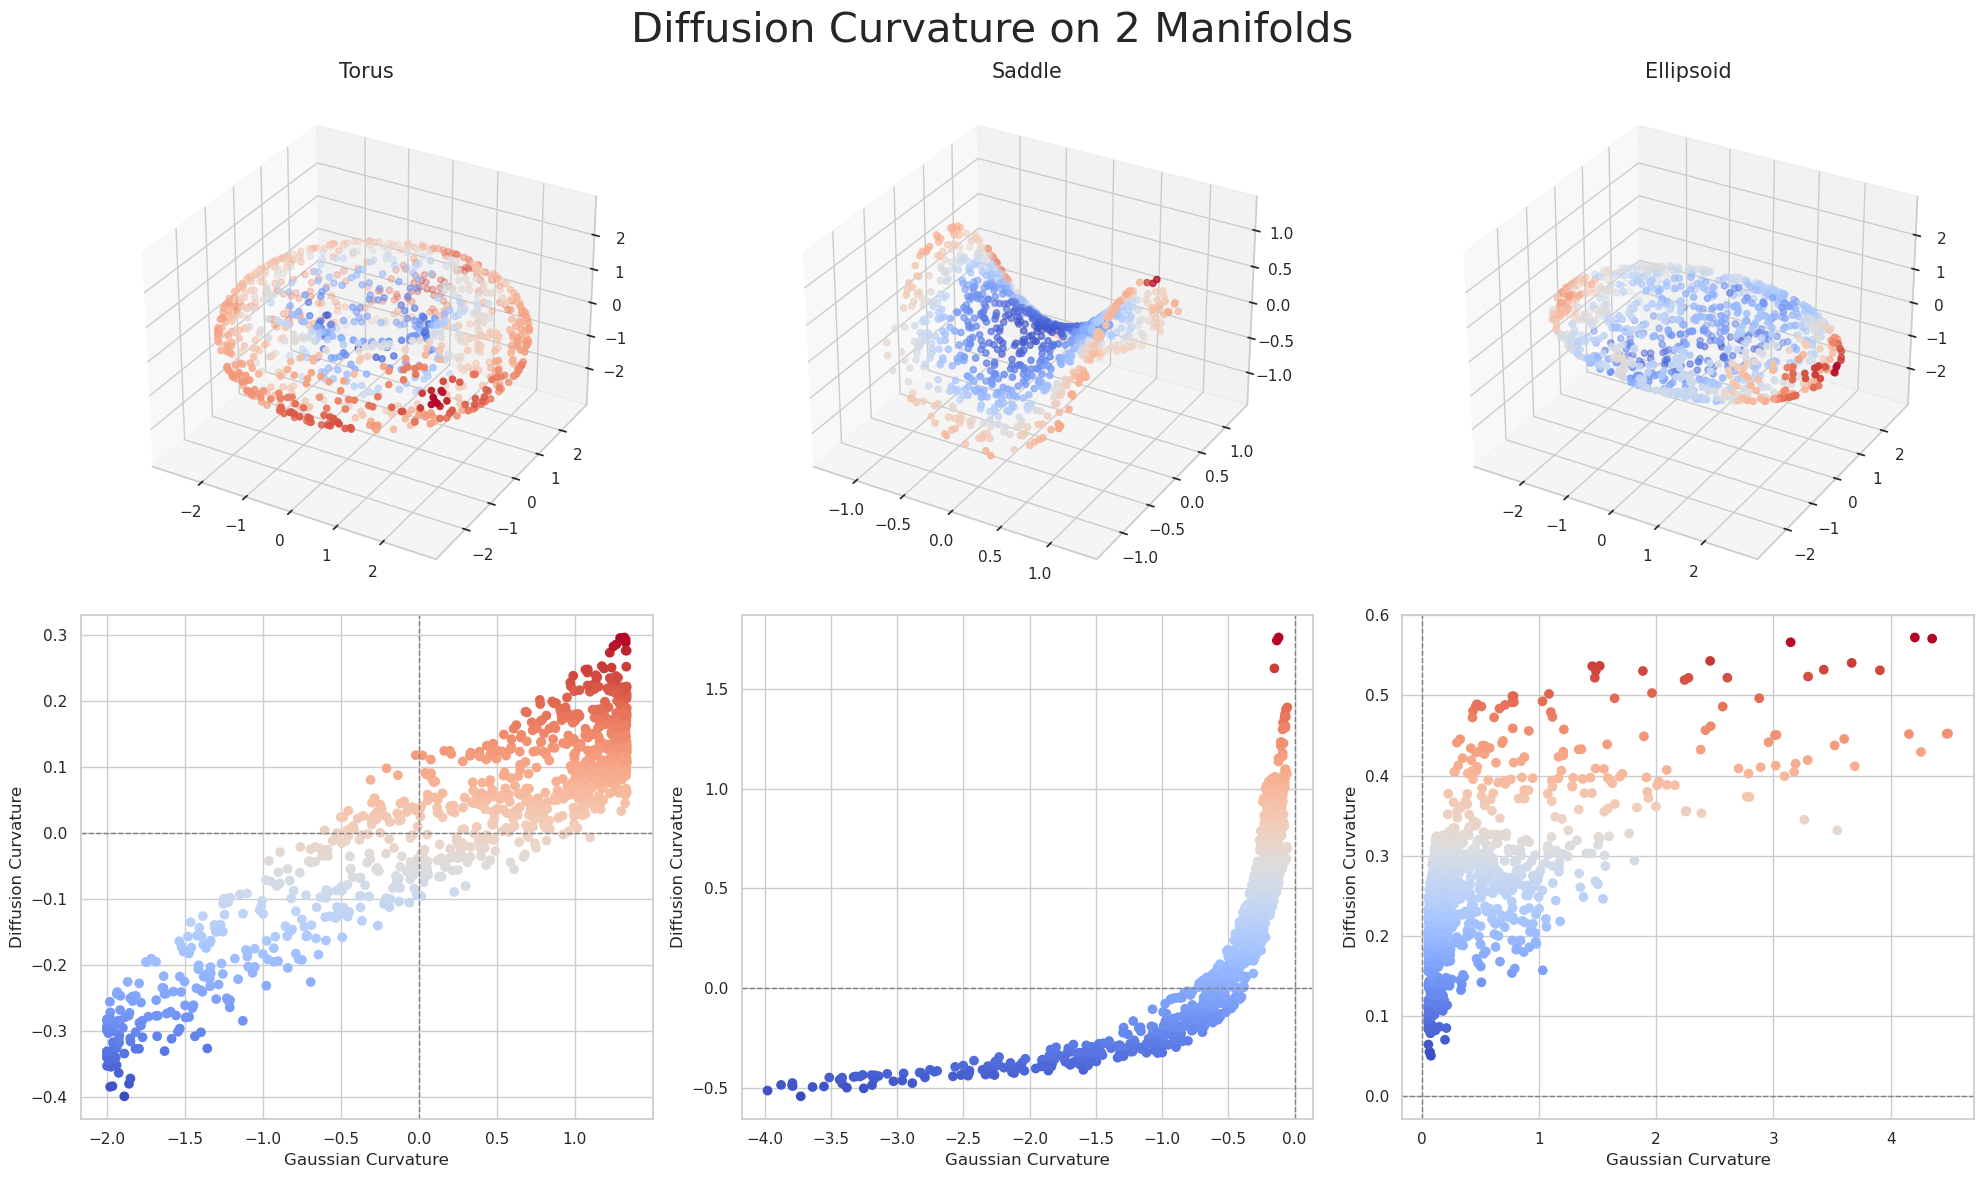
<figcaption>Figure 1: Diffusion Curvature vs Gaussian Curvature on 2-Manifolds.</figcaption>
</figure>

Though the correlation is strong – passing the ‘sniff test’ – this low-dimensional validation highlights two subtleties of our method. First, diffusion curvature, being an intrinsic, graph-based measurement, is susceptible to edge effects to a greater degree than extrinsic methods. When diffusion hits the edges of the saddle, it rebounds, creating the false appearance of positive curvature.

``` python
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from matplotlib import colors
import numpy as np

# Assuming Xs, labels, ground_truth_labels, and key_names are defined
# For example:
key_names = ['Torus', 'Saddle', 'Ellipsoid']
labels = curvatures
ground_truth_labels = Ks

# Set the style of seaborn
sns.set(style="whitegrid")

fig_shape = (len(curvatures.keys()) + 1, len(key_names))
method_colors = ['green', 'olive', 'navy', 'orange', 'purple']
assert len(method_colors) == len(curvatures.keys())

ordered_keys = curvatures.keys() #['Gaussian', 'Adal-PCA', 'Unsigned Diffusion Curvature', 'Hickok & Blumberg']
assert set(ordered_keys) == set(curvatures.keys())

# Create a figure and axes with 2 rows and 3 columns
fig, axs = plt.subplots(fig_shape[0], fig_shape[1], figsize=(fig_shape[0]*2, fig_shape[1]*5), subplot_kw={'projection': '3d'} if plt.matplotlib.__version__ < '3.4.0' else None)

for i, key in enumerate(key_names):
    # 3D scatter plot for the first row
    lim = np.max(np.linalg.norm(Xs[key], axis=1))
    # if plt.matplotlib.__version__ >= '3.4.0':

    # plot the curvature for each method
    for j, method_name in enumerate(ordered_keys):
        axs[j, i].remove()
        axs[j, i] = fig.add_subplot(fig_shape[0], fig_shape[1], i + j*fig_shape[1] + 1, projection='3d')
        axs[j, i].axes.set_xlim3d(left=-lim, right=lim)
        axs[j, i].axes.set_ylim3d(bottom=-lim, top=lim)
        axs[j, i].axes.set_zlim3d(bottom=-lim, top=lim)
        axs[j, i].set_xticks([])
        axs[j, i].set_yticks([])
        axs[j, i].set_zticks([])

        scaled_labels = labels[method_name][key]
        scaled_labels = scaled_labels / (max(scaled_labels) - min(scaled_labels))
        scatter3d = axs[j, i].scatter(Xs[key][:, 0], Xs[key][:, 1], Xs[key][:, 2], c=scaled_labels, cmap = 'coolwarm')
        if i == 1:
            axs[j, i].set_title(f'{method_name}',fontsize=15, c = method_colors[j])

    # Scatter plot for the second row, colored by labels
    # axs[j+1, i].remove()
    # axs[j+1, i] = fig.add_subplot(fig_shape[0], fig_shape[1], i+4)
    for k, method_name in enumerate(ordered_keys):
        # min max scaling
        scaled_labels = labels[method_name][key]
        scaled_labels = scaled_labels / (max(scaled_labels) - min(scaled_labels))
        scatter2d = axs[j+1, i].scatter(ground_truth_labels[key], scaled_labels, c = method_colors[k], s = 1)
        axs[j+1,i].set_aspect('equal')
    # axs[1, i].set_title(f'')
    axs[j+1, i].set_xlabel('Gaussian Curvature')
    axs[j+1, i].set_ylabel('Estimated Curvature')
    
    
    # Highlight the origin lines in 2D scatter plots
    axs[j+1, i].axhline(0, color='gray', linewidth=1, linestyle='--')
    axs[j+1, i].axvline(0, color='gray', linewidth=1, linestyle='--')

    # # Add colorbar for each subplot
    # fig.colorbar(scatter3d, ax=axs[0, i], fraction=0.046, pad=0.04)
    # fig.colorbar(scatter2d, ax=axs[1, i], fraction=0.046, pad=0.04)
plt.suptitle("Estimated Gaussian Curvatures of 2-Manifolds", fontsize=30)
plt.tight_layout()
plt.show()
```

<figure id="fig-2-manifolds-visual-comparison">
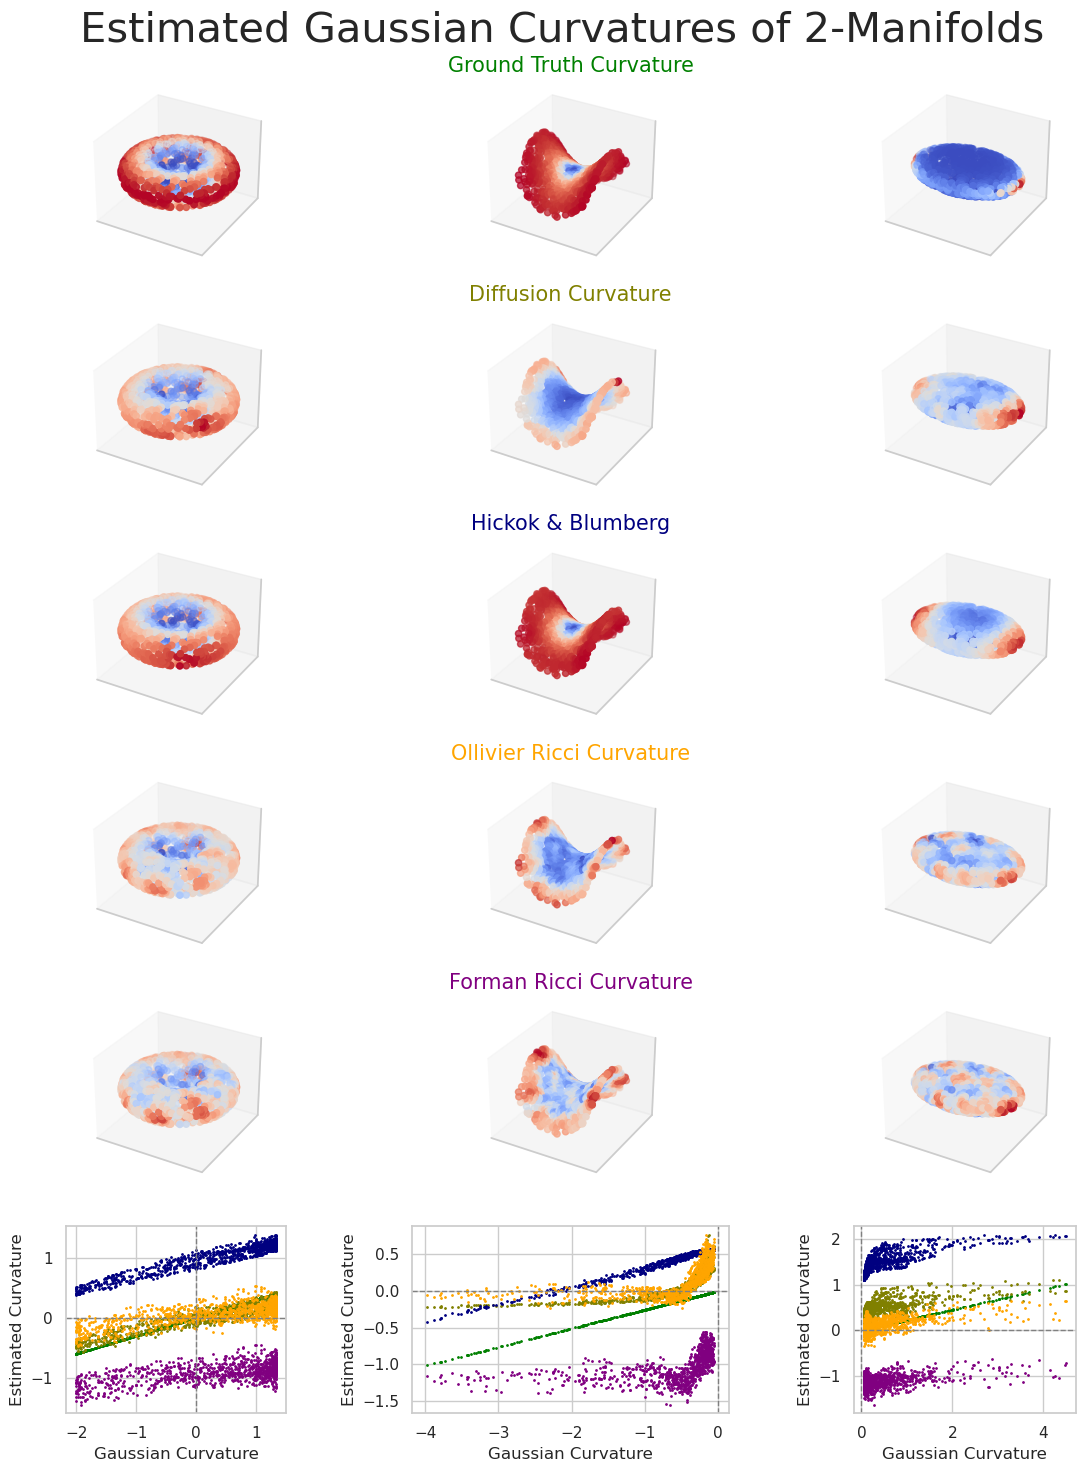
<figcaption>Figure 2: Diffusion Curvature vs Gaussian Curvature on 2-Manifolds.</figcaption>
</figure>

The second subtly emerges in the context of related methods. Everything pictured does an excellent job of coloring the toy manifolds. But looking beyond this, *what matters?* Most methods don’t care about the precise magnitude – or even exactly matching the correlations, as in the ellipsoid… %% mean vs gaussian curvature, and uniqueness of definitions%%

All of these methods in <a href="#fig-2-manifolds-visual-comparison" class="quarto-xref">Figure 2</a> perform well on well-sampled noiseless toy manifolds. In Table <a href="#fig-2-manifolds-noise-table" class="quarto-xref">Figure 3</a>, we see the results of adding Gaussian noise to each manifold.

``` python
from great_tables import GT, style, loc, exibble
from great_tables.data import sp500
import pandas as pd

df = metric_df

# Group the data by metric for proper sorting and display
df = df.sort_values(by=['Metric', 'Model']).reset_index(drop=True)

# Create the table with row groups
table = (
    GT(df, rowname_col="Model", groupname_col="Metric")
    .tab_header(title="Curvature under Noise", subtitle="2-Manifolds with Noise")
    .tab_stubhead(label="Model & Metric")
    .cols_label(
        Model="Model",
        Metric="Metric",
        **{col: col for col in df.columns if col not in ["Model", "Metric"]}
    )
    .tab_spanner(label="Torus", columns=[col for col in df.columns if "Torus" in col])
    .tab_spanner(label="Ellipsoid", columns=[col for col in df.columns if "Ellipsoid" in col])
    .tab_spanner(label="Saddle", columns=[col for col in df.columns if "Saddle" in col])
    .fmt_number(columns=[col for col in df.columns if col not in ["Model", "Metric"]], decimals=3)
)

# Function to apply styles to the best values
def apply_best_value_styles(df, table):
    for metric in df['Metric'].unique():
        metric_df = df[df['Metric'] == metric]
        for col in df.columns[2:]:
            if metric == 'PCC':
                best_value = metric_df[col].max()
            else:  # For RMSE and other metrics where lower is better
                best_value = metric_df[col].min()
                
            best_indices = metric_df[metric_df[col] == best_value].index.tolist()
            for index in best_indices:
                table = table.tab_style(
                    style=style.text(weight="bold"),
                    locations=loc.body(columns=[col], rows=[index])
                )
    return table

# Apply the styles
table = apply_best_value_styles(df, table)

# Display the table (assuming in Jupyter Notebook)
display(table)
```

<div id="bkcvkbofuz" style="padding-left:0px;padding-right:0px;padding-top:10px;padding-bottom:10px;overflow-x:auto;overflow-y:auto;width:auto;height:auto;">
<style>
#bkcvkbofuz table {
          font-family: -apple-system, BlinkMacSystemFont, 'Segoe UI', Roboto, Oxygen, Ubuntu, Cantarell, 'Helvetica Neue', 'Fira Sans', 'Droid Sans', Arial, sans-serif;
          -webkit-font-smoothing: antialiased;
          -moz-osx-font-smoothing: grayscale;
        }

#bkcvkbofuz thead, tbody, tfoot, tr, td, th { border-style: none; }
 tr { background-color: transparent; }
#bkcvkbofuz p { margin: 0; padding: 0; }
 #bkcvkbofuz .gt_table { display: table; border-collapse: collapse; line-height: normal; margin-left: auto; margin-right: auto; color: #333333; font-size: 16px; font-weight: normal; font-style: normal; background-color: #FFFFFF; width: auto; border-top-style: solid; border-top-width: 2px; border-top-color: #A8A8A8; border-right-style: none; border-right-width: 2px; border-right-color: #D3D3D3; border-bottom-style: solid; border-bottom-width: 2px; border-bottom-color: #A8A8A8; border-left-style: none; border-left-width: 2px; border-left-color: #D3D3D3; }
 #bkcvkbofuz .gt_caption { padding-top: 4px; padding-bottom: 4px; }
 #bkcvkbofuz .gt_title { color: #333333; font-size: 125%; font-weight: initial; padding-top: 4px; padding-bottom: 4px; padding-left: 5px; padding-right: 5px; border-bottom-color: #FFFFFF; border-bottom-width: 0; }
 #bkcvkbofuz .gt_subtitle { color: #333333; font-size: 85%; font-weight: initial; padding-top: 3px; padding-bottom: 5px; padding-left: 5px; padding-right: 5px; border-top-color: #FFFFFF; border-top-width: 0; }
 #bkcvkbofuz .gt_heading { background-color: #FFFFFF; text-align: center; border-bottom-color: #FFFFFF; border-left-style: none; border-left-width: 1px; border-left-color: #D3D3D3; border-right-style: none; border-right-width: 1px; border-right-color: #D3D3D3; }
 #bkcvkbofuz .gt_bottom_border { border-bottom-style: solid; border-bottom-width: 2px; border-bottom-color: #D3D3D3; }
 #bkcvkbofuz .gt_col_headings { border-top-style: solid; border-top-width: 2px; border-top-color: #D3D3D3; border-bottom-style: solid; border-bottom-width: 2px; border-bottom-color: #D3D3D3; border-left-style: none; border-left-width: 1px; border-left-color: #D3D3D3; border-right-style: none; border-right-width: 1px; border-right-color: #D3D3D3; }
 #bkcvkbofuz .gt_col_heading { color: #333333; background-color: #FFFFFF; font-size: 100%; font-weight: normal; text-transform: inherit; border-left-style: none; border-left-width: 1px; border-left-color: #D3D3D3; border-right-style: none; border-right-width: 1px; border-right-color: #D3D3D3; vertical-align: bottom; padding-top: 5px; padding-bottom: 5px; padding-left: 5px; padding-right: 5px; overflow-x: hidden; }
 #bkcvkbofuz .gt_column_spanner_outer { color: #333333; background-color: #FFFFFF; font-size: 100%; font-weight: normal; text-transform: inherit; padding-top: 0; padding-bottom: 0; padding-left: 4px; padding-right: 4px; }
 #bkcvkbofuz .gt_column_spanner_outer:first-child { padding-left: 0; }
 #bkcvkbofuz .gt_column_spanner_outer:last-child { padding-right: 0; }
 #bkcvkbofuz .gt_column_spanner { border-bottom-style: solid; border-bottom-width: 2px; border-bottom-color: #D3D3D3; vertical-align: bottom; padding-top: 5px; padding-bottom: 5px; overflow-x: hidden; display: inline-block; width: 100%; }
 #bkcvkbofuz .gt_spanner_row { border-bottom-style: hidden; }
 #bkcvkbofuz .gt_group_heading { padding-top: 8px; padding-bottom: 8px; padding-left: 5px; padding-right: 5px; color: #333333; background-color: #FFFFFF; font-size: 100%; font-weight: initial; text-transform: inherit; border-top-style: solid; border-top-width: 2px; border-top-color: #D3D3D3; border-bottom-style: solid; border-bottom-width: 2px; border-bottom-color: #D3D3D3; border-left-style: none; border-left-width: 1px; border-left-color: #D3D3D3; border-right-style: none; border-right-width: 1px; border-right-color: #D3D3D3; vertical-align: middle; text-align: left; }
 #bkcvkbofuz .gt_empty_group_heading { padding: 0.5px; color: #333333; background-color: #FFFFFF; font-size: 100%; font-weight: initial; border-top-style: solid; border-top-width: 2px; border-top-color: #D3D3D3; border-bottom-style: solid; border-bottom-width: 2px; border-bottom-color: #D3D3D3; vertical-align: middle; }
 #bkcvkbofuz .gt_from_md> :first-child { margin-top: 0; }
 #bkcvkbofuz .gt_from_md> :last-child { margin-bottom: 0; }
 #bkcvkbofuz .gt_row { padding-top: 8px; padding-bottom: 8px; padding-left: 5px; padding-right: 5px; margin: 10px; border-top-style: solid; border-top-width: 1px; border-top-color: #D3D3D3; border-left-style: none; border-left-width: 1px; border-left-color: #D3D3D3; border-right-style: none; border-right-width: 1px; border-right-color: #D3D3D3; vertical-align: middle; overflow-x: hidden; }
 #bkcvkbofuz .gt_stub { color: #333333; background-color: #FFFFFF; font-size: 100%; font-weight: initial; text-transform: inherit; border-right-style: solid; border-right-width: 2px; border-right-color: #D3D3D3; padding-left: 5px; padding-right: 5px; }
 #bkcvkbofuz .gt_stub_row_group { color: #333333; background-color: #FFFFFF; font-size: 100%; font-weight: initial; text-transform: inherit; border-right-style: solid; border-right-width: 2px; border-right-color: #D3D3D3; padding-left: 5px; padding-right: 5px; vertical-align: top; }
 #bkcvkbofuz .gt_row_group_first td { border-top-width: 2px; }
 #bkcvkbofuz .gt_row_group_first th { border-top-width: 2px; }
 #bkcvkbofuz .gt_table_body { border-top-style: solid; border-top-width: 2px; border-top-color: #D3D3D3; border-bottom-style: solid; border-bottom-width: 2px; border-bottom-color: #D3D3D3; }
 #bkcvkbofuz .gt_sourcenotes { color: #333333; background-color: #FFFFFF; border-bottom-style: none; border-bottom-width: 2px; border-bottom-color: #D3D3D3; border-left-style: none; border-left-width: 2px; border-left-color: #D3D3D3; border-right-style: none; border-right-width: 2px; border-right-color: #D3D3D3; }
 #bkcvkbofuz .gt_sourcenote { font-size: 90%; padding-top: 4px; padding-bottom: 4px; padding-left: 5px; padding-right: 5px; text-align: left; }
 #bkcvkbofuz .gt_left { text-align: left; }
 #bkcvkbofuz .gt_center { text-align: center; }
 #bkcvkbofuz .gt_right { text-align: right; font-variant-numeric: tabular-nums; }
 #bkcvkbofuz .gt_font_normal { font-weight: normal; }
 #bkcvkbofuz .gt_font_bold { font-weight: bold; }
 #bkcvkbofuz .gt_font_italic { font-style: italic; }
 #bkcvkbofuz .gt_super { font-size: 65%; }
 #bkcvkbofuz .gt_footnote_marks { font-size: 75%; vertical-align: 0.4em; position: initial; }
 #bkcvkbofuz .gt_asterisk { font-size: 100%; vertical-align: 0; }
 
</style>

| Curvature under Noise    |                                              |                   |                   |                                               |                    |                    |                                                  |                       |                       |
|--------------------------|----------------------------------------------|-------------------|-------------------|-----------------------------------------------|--------------------|--------------------|--------------------------------------------------|-----------------------|-----------------------|
| 2-Manifolds with Noise   |                                              |                   |                   |                                               |                    |                    |                                                  |                       |                       |
| Model & Metric           | <span class="gt_column_spanner">Torus</span> |                   |                   | <span class="gt_column_spanner">Saddle</span> |                    |                    | <span class="gt_column_spanner">Ellipsoid</span> |                       |                       |
|                          | Torus                                        | Torus noise = 0.1 | Torus noise = 0.2 | Saddle                                        | Saddle noise = 0.1 | Saddle noise = 0.2 | Ellipsoid                                        | Ellipsoid noise = 0.1 | Ellipsoid noise = 0.2 |
| ED                       |                                              |                   |                   |                                               |                    |                    |                                                  |                       |                       |
| Diffusion Curvature      | 0.774                                        | 0.867             | 0.938             | 0.829                                         | 0.517              | 0.234              | 0.331                                            | 0.667                 | 1.116                 |
| Forman Ricci Curvature   | 6.832                                        | 6.726             | 6.508             | 8.307                                         | 8.432              | 8.888              | 7.693                                            | 7.643                 | 7.498                 |
| Hickok & Blumberg        | 0.961                                        | 0.556             | 0.353             | 2.138                                         | 0.953              | 1.455              | 1.070                                            | 0.319                 | 1.055                 |
| Ollivier Ricci Curvature | 0.845                                        | 0.837             | 0.826             | 0.792                                         | 0.847              | 0.843              | 0.587                                            | 0.551                 | 0.507                 |
| PCC                      |                                              |                   |                   |                                               |                    |                    |                                                  |                       |                       |
| Diffusion Curvature      | 0.921                                        | 0.951             | 0.958             | 0.753                                         | 0.766              | 0.673              | 0.625                                            | 0.589                 | 0.614                 |
| Forman Ricci Curvature   | 0.558                                        | 0.575             | 0.598             | 0.466                                         | 0.482              | 0.522              | 0.412                                            | 0.373                 | 0.332                 |
| Hickok & Blumberg        | 0.954                                        | 0.945             | 0.856             | 0.992                                         | 0.904              | 0.749              | 0.727                                            | 0.706                 | 0.575                 |
| Ollivier Ricci Curvature | 0.687                                        | 0.677             | 0.636             | 0.566                                         | 0.484              | 0.558              | 0.596                                            | 0.560                 | 0.488                 |
| RMSE                     |                                              |                   |                   |                                               |                    |                    |                                                  |                       |                       |
| Diffusion Curvature      | 0.937                                        | 1.007             | 1.080             | 1.039                                         | 0.742              | 0.603              | 0.690                                            | 0.861                 | 1.174                 |
| Forman Ricci Curvature   | 26.794                                       | 26.252            | 25.478            | 40.008                                        | 41.765             | 47.088             | 32.479                                           | 32.071                | 31.611                |
| Hickok & Blumberg        | 1.359                                        | 0.928             | 0.601             | 3.108                                         | 1.912              | 4.246              | 0.983                                            | 0.547                 | 1.222                 |
| Ollivier Ricci Curvature | 1.044                                        | 1.038             | 1.032             | 0.975                                         | 1.012              | 1.006              | 0.838                                            | 0.825                 | 0.810                 |

</div>
        

Figure 3: Performance of methods under noise on 2-Manifolds with Noise.

### 4.0.1 Differentiating Sign in High Dimensions

Most existing methods only quantify their performance in high dimensions on one or two test cases.

``` python
SS1._aggregate_labels()
SS1.plot_by_dimension()
```

<figure id="fig-sadspheres">
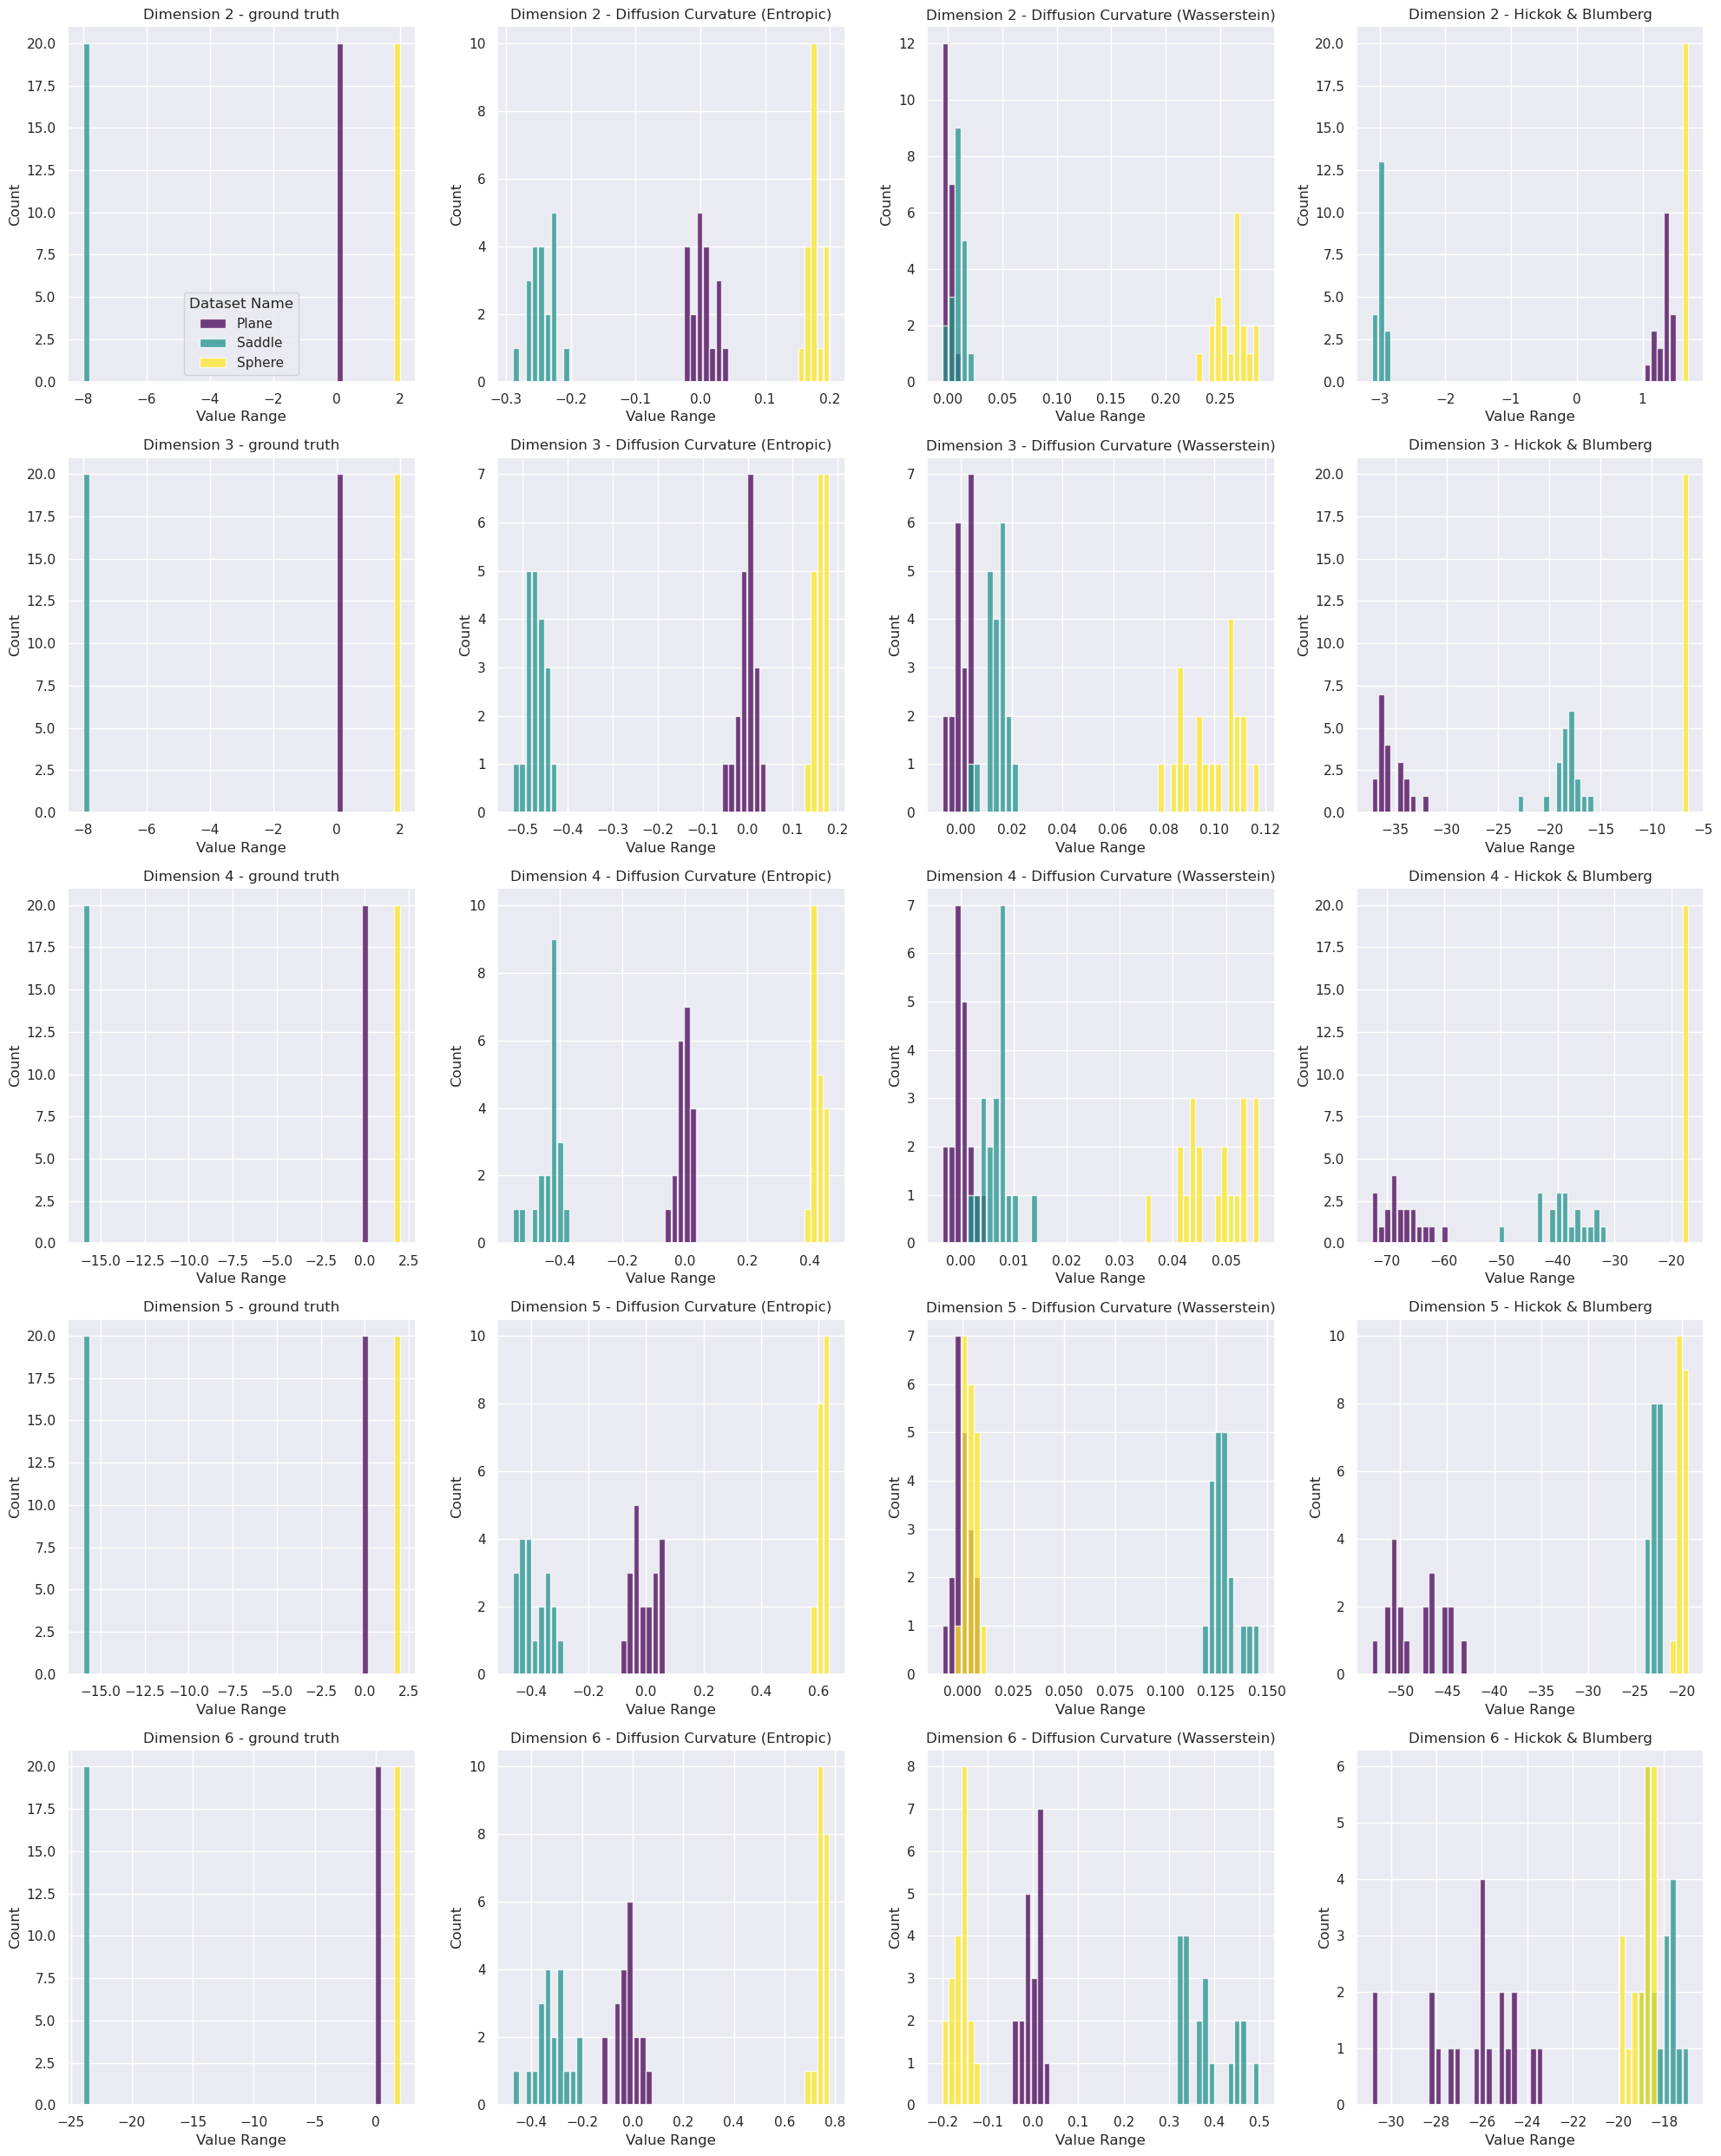
<figcaption>Figure 4: Predicted curvatures of Saddles and Spheres in dimensions 2-6. Diffusion Curvature robustly distinguishes between the signs of the data, even in high dimensions, and with relative sparsity.</figcaption>
</figure>

## 4.1 Loss Landscapes

## 4.2 Curvature as a TDA Filtration

# 5. Related Work

## 5.1 Foreman Ricci Curvature

## 5.2 Hickock & Blumberg’s Volume Comparison Curvature

# 6. Conclusion

# References

Bhaskar, Dhananjay, Kincaid MacDonald, Oluwadamilola Fasina, Dawson Thomas, Bastian Rieck, Ian Adelstein, and Smita Krishnaswamy. 2022. “Diffusion Curvature for Estimating Local Curvature in High Dimensional Data.” *Advances in Neural Information Processing Systems* 35: 21738–49. <https://proceedings.neurips.cc/paper_files/paper/2022/hash/88438dc62fc5c8777e2b5f1b4f6d37a2-Abstract-Conference.html>.

“Bishop–Gromov Inequality.” 2021. In *Wikipedia*. <https://en.wikipedia.org/w/index.php?title=Bishop%E2%80%93Gromov_inequality&oldid=1059331416>.

Coifman, Ronald R., and Stéphane Lafon. 2006. “Diffusion Maps.” *Applied and Computational Harmonic Analysis*, Special Issue: Diffusion Maps and Wavelets, 21 (1): 5–30. <https://doi.org/10.1016/j.acha.2006.04.006>.

Hickok, Abigail, and Andrew J. Blumberg. 2023. “An Intrinsic Approach to Scalar-Curvature Estimation for Point Clouds.” arXiv. <https://doi.org/10.48550/arXiv.2308.02615>.

Huguet, Guillaume, Alexander Tong, Edward De Brouwer, Yanlei Zhang, Guy Wolf, Ian Adelstein, and Smita Krishnaswamy. 2023. “A Heat Diffusion Perspective on Geodesic Preserving Dimensionality Reduction.” May 30, 2023. <https://doi.org/10.48550/arXiv.2305.19043>.

Maaten, Laurens van der, and Geoffrey Hinton. 2008. “Visualizing Data Using t-SNE.” *Journal of Machine Learning Research* 9 (86): 2579–2605. <http://jmlr.org/papers/v9/vandermaaten08a.html>.

Moon, Kevin R., David van Dijk, Zheng Wang, Scott Gigante, Daniel B. Burkhardt, William S. Chen, Kristina Yim, et al. 2019. “Visualizing Structure and Transitions in High-Dimensional Biological Data.” *Nature Biotechnology* 37 (12, 12): 1482–92. <https://doi.org/10.1038/s41587-019-0336-3>.

Ollivier, Yann. 2009. “Ricci Curvature of Markov Chains on Metric Spaces.” *Journal of Functional Analysis* 256 (3): 810–64. <https://doi.org/10.1016/j.jfa.2008.11.001>.

Saloff-Coste, Laurent. 2010. “The Heat Kernel and Its Estimates.” In *Advanced Studies in Pure Mathematics*, 405–36. Kyoto University, Japan. <https://doi.org/10.2969/aspm/05710405>.

Steinerberger, Stefan. 2022. “Curvature on Graphs via Equilibrium Measures.” September 5, 2022. <https://doi.org/10.48550/arXiv.2202.01658>.

Sturm, Karl-Theodor. 2006. “On the Geometry of Metric Measure Spaces.” *Acta Mathematica* 196 (1): 65–131. <https://doi.org/10.1007/s11511-006-0002-8>.

Tong, Alexander Y., Guillaume Huguet, Amine Natik, Kincaid Macdonald, Manik Kuchroo, Ronald Coifman, Guy Wolf, and Smita Krishnaswamy. 2021. “Diffusion Earth Mover’s Distance and Distribution Embeddings.” In *Proceedings of the 38th International Conference on Machine Learning*, 10336–46. PMLR. <https://proceedings.mlr.press/v139/tong21a.html>.

Tong, Alexander, Frederick Wenkel, Kincaid Macdonald, Smita Krishnaswamy, and Guy Wolf. 2021. “Data-Driven Learning of Geometric Scattering Modules for Gnns.” In *2021 IEEE 31st International Workshop on Machine Learning for Signal Processing (MLSP)*, 1–6. IEEE. <https://ieeexplore.ieee.org/abstract/document/9596169/>.

[1] Consider kernel density estimation, where one places gaussians on each data point and sums up the probability assigned to each area. The higher the curvature, the higher the reported density, since at the end of an ellipsoid the gaussians have greater overlap with each other than in its center – even though the intrinsic density of the surface is uniform.

[2] For instance, one could construct a comparison graph which matched the 1-step diffusion laziness of the input graph, after suitable denoising.